<a href="https://colab.research.google.com/github/IA2021UR/trabajo-ia-en-la-comunidad-de-la-rioja-equipo-4/blob/main/comparacion_modelos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Comparativa de modelos**

Las imágenes se han tratado con tamaño 128, no es el adecuado ya que se pierde mucha información. Se deberían de tratar 256 o 512, pero el entrenamiento para la comparativa de modelos llevaría demasiado tiempo y recursos (GPU)

Con un tamaño de 256 o 512 el reescalado a 1024 o superior con inteligencia artificial da buenos resultados.

In [ ]:
!pip install visualkeras
import visualkeras

In [ ]:
model = gan
visualkeras.layered_view(model).show() # display using your system viewer
visualkeras.layered_view(model, to_file='output.png') # write to disk
visualkeras.layered_view(model, to_file='output.png').show() # write and show

In [1]:
!wget --no-check-certificate https://ferminjimenez.com/data/images.zip -O images.zip
!unzip -qq images.zip

images.zip          100%[===================>] 840.08M  20.0MB/s    in 45s     

2021-05-28 16:40:52 (18.6 MB/s) - ‘images.zip’ saved [880890554/880890554]



In [ ]:
!wget https://github.com/ml5js/ml5-data-and-models/raw/master/datasets/images/landscapes/landscapes_small.zip
!unzip -qq landscapes_small.zip

In [1]:
from keras.models import Model
from keras.layers import InputLayer, Conv2D,concatenate, Concatenate, MaxPooling2D, Activation, BatchNormalization,MaxPool2D, UpSampling2D, Dropout, Flatten, Dense, Input, LeakyReLU, Conv2DTranspose, AveragePooling2D
from keras.optimizers import Adam
from keras.models import Sequential
import keras.models as models
from sklearn.model_selection import train_test_split
import cv2
import matplotlib.pyplot as plt
import numpy as np
from glob import glob
from PIL import Image
import random
from skimage import color, io
from skimage.transform import resize
import tensorflow as tf
from keras import backend as K
sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(log_device_placement=True))
tf.config.list_physical_devices('GPU')

Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5



[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# Funciones

In [2]:
def load_image(file):
  image_orig = cv2.imread(file)
  image_rgb = cv2.cvtColor(image_orig,cv2.COLOR_BGR2RGB) / 255.
  image_rgb = np.array(image_rgb, dtype='float32')
  image = cv2.resize(image_rgb, (128, 128))
  return image

def image_to_lab(image):
  image = np.array(cv2.cvtColor(image,cv2.COLOR_RGB2LAB))
  image = cv2.resize(image, (128, 128))
  return image

def image_to_rgb(image):
  image = np.array(cv2.cvtColor(image,cv2.COLOR_LAB2RGB))
  image = cv2.resize(image, (128, 128))
  return image

def normalize_array_lab(arr):
  arr[:,:,0] = arr[:,:,0] / 255

  arr[:,:,1] = arr[:,:,1] + 127
  arr[:,:,1] = arr[:,:,1] / 255
  
  arr[:,:,2] = arr[:,:,2] + 127
  arr[:,:,2] = arr[:,:,2] / 255
  
  arr = arr * 2
  arr = arr - 1
  return arr

def de_normalize_array_lab(arr):
  arr = arr + 1
  arr = arr / 2

  arr[:,:,0] = arr[:,:,0] * 255

  arr[:,:,1] = arr[:,:,1] * 255
  arr[:,:,1] = arr[:,:,1] - 127

  arr[:,:,2] = arr[:,:,2] * 255
  arr[:,:,2] = arr[:,:,2] - 127
  return arr

def image_to_lab_l_norm(image):
  image = image_to_lab(image)
  image = normalize_array_lab(image)
  return image[:,:,0].reshape(128, 128, 1)

def image_to_lab_ab_norm(image):
  image = image_to_lab(image)
  image = normalize_array_lab(image)
  return image[:,:,1:].reshape(128, 128, 2)
  
def image_l_ab_to_rgb(l , ab):
  image = np.zeros((128,128,3)).astype('float32')
  image[:,:,0] = l.reshape(128, 128, 1)[:,:,0]
  image[:,:,1:] = ab
  
  image = np.array(image).astype('float32')

  image = de_normalize_array_lab(image)

  return image_to_rgb(image)




# Models

### Discriminator

Imagen del la arquitectura del discriminador

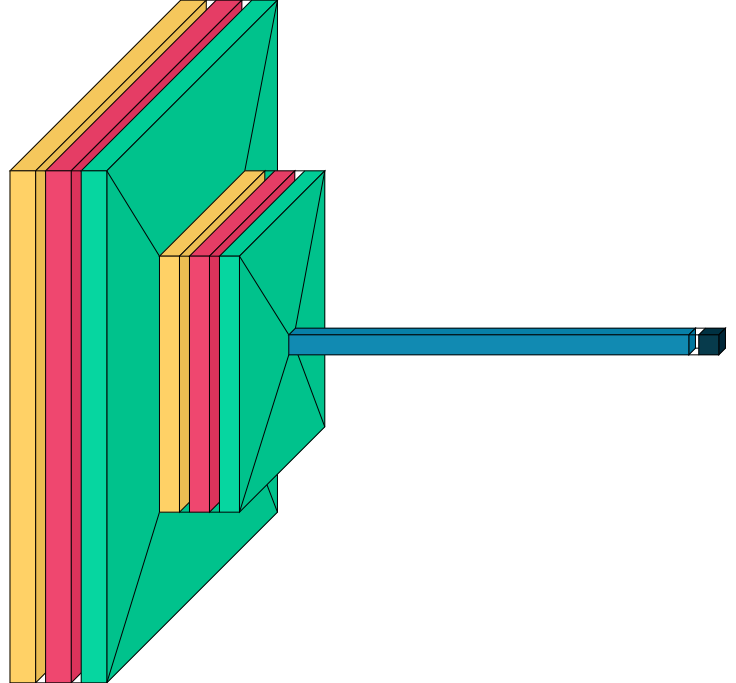

In [3]:
def build_discriminator():
  input_shape = (128,128, 2)
  model = Sequential()
  model.add(Conv2D(256, kernel_size=(5,5), strides=(2,2), padding="same" ,input_shape=input_shape))
  model.add(LeakyReLU())
  model.add(Dropout(0.3))
  model.add(Conv2D(128, kernel_size=(5,5), strides=(2,2), padding="same"))
  model.add(LeakyReLU())
  model.add(Dropout(0.3))
  model.add(Flatten())
  model.add(Dense(1, activation="sigmoid"))
  return model

def compile_discriminator(model):
  opt = Adam(lr=.0001, beta_1=0.9)
  #model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
  model.compile(optimizer='rmsprop',loss='mse', metrics=['accuracy'])
  model.trainable = True
  return model

def save_discriminator(model):
  model.save('discriminator.h5', overwrite=True)

def load_discriminator():
  return models.load_model('discriminator.h5')

### Generator

Arquitectura del modelo *generador*

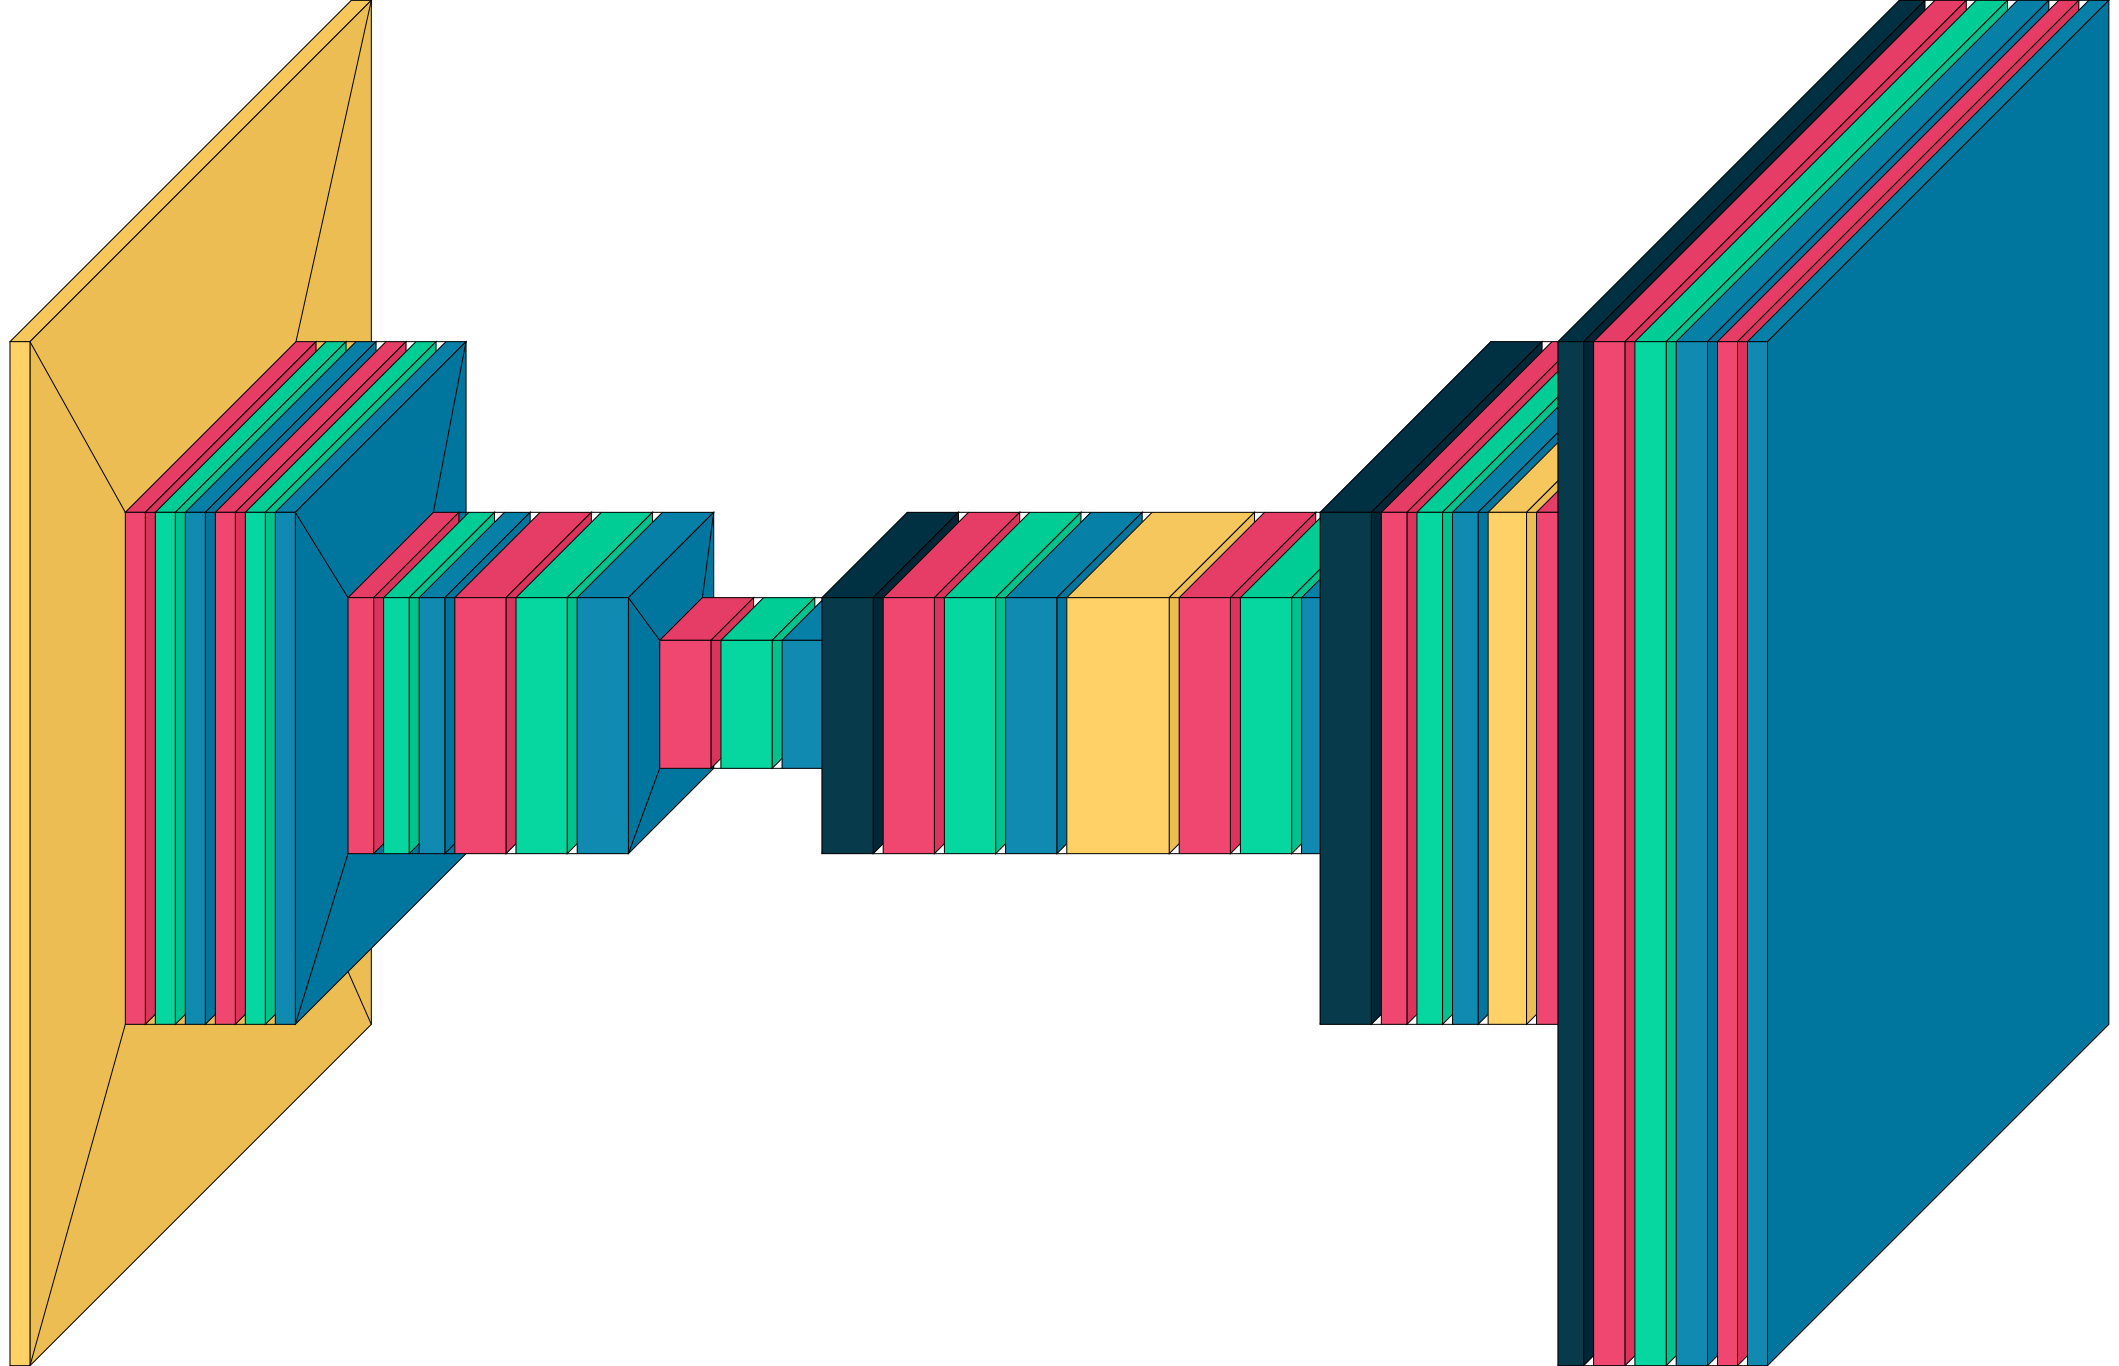

In [4]:
def build_generator():
  g_input_shape = (128,128, 1)
  g_input = Input(shape=g_input_shape)

  conv1 = Conv2D(64, (3, 3), padding='same', strides=2)(g_input)
  conv1 = BatchNormalization()(conv1)
  conv1 = Activation('relu')(conv1)

  conv2 = Conv2D(128, (3, 3), padding='same', strides=1)(conv1)
  conv2 = BatchNormalization()(conv2)
  conv2 = Activation('relu')(conv2)

  conv3 = Conv2D(256, (3, 3), padding='same', strides=2)(conv2)
  conv3 = BatchNormalization()(conv3)
  conv3 = Activation('relu')(conv3)

  conv4 = Conv2D(512, (3, 3), padding='same', strides=1)(conv3)
  conv4 = BatchNormalization()(conv4)
  conv4 = Activation('relu')(conv4)

  conv5 = Conv2D(512, (3, 3), padding='same', strides=2)(conv4)
  conv5 = BatchNormalization()(conv5)
  conv5 = Activation('relu')(conv5)

  conv7 = UpSampling2D(size=(2, 2))(conv5)
  conv7 = Conv2D(512, (3, 3), padding='same')(conv7)
  conv7 = BatchNormalization()(conv7)
  conv7 = Activation('relu')(conv7)
  conv7 = Concatenate(axis=-1)([conv7,conv4])

  conv8 = Conv2D(512, (3, 3), padding='same')(conv7)
  conv8 = BatchNormalization()(conv8)
  conv8 = Activation('relu')(conv8)

  up2 = UpSampling2D(size=(2, 2))(conv8)
  conv9 = Conv2D(256, (3,3), padding='same')(up2)
  conv9 = BatchNormalization()(conv9)
  conv9 = Activation('relu')(conv9)
  conv9 = Concatenate(axis=-1)([conv9,conv2])

  conv10 = Conv2D(256, (3, 3), padding='same')(conv9)
  conv10 = BatchNormalization()(conv10)
  conv10 = Activation('relu')(conv10)

  up3 = UpSampling2D(size=(2, 2))(conv10)
  conv11 = Conv2D(313, (1,1), padding='same')(up3)
  conv11 = BatchNormalization()(conv11)
  conv11 = Activation('relu')(conv11)

  conv12 = Conv2D(2, (1, 1), padding='same')(conv11)
  conv12 = Activation('tanh')(conv12)

  return Model(inputs=g_input,outputs=conv12)

def compile_generator(model):
  opt = Adam(lr=.001, beta_1=0.7)
  model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
  return model

def save_generator(model):
  model.save('generator.h5', overwrite=True)

def load_generator():
  return models.load_model('generator.h5')



### Generator UNET

Arquitectura del modelo generador UNET, no se reflejan las conexiones que se realizan entre ambos lados de la red que son tipicas de la arquitectura UNET

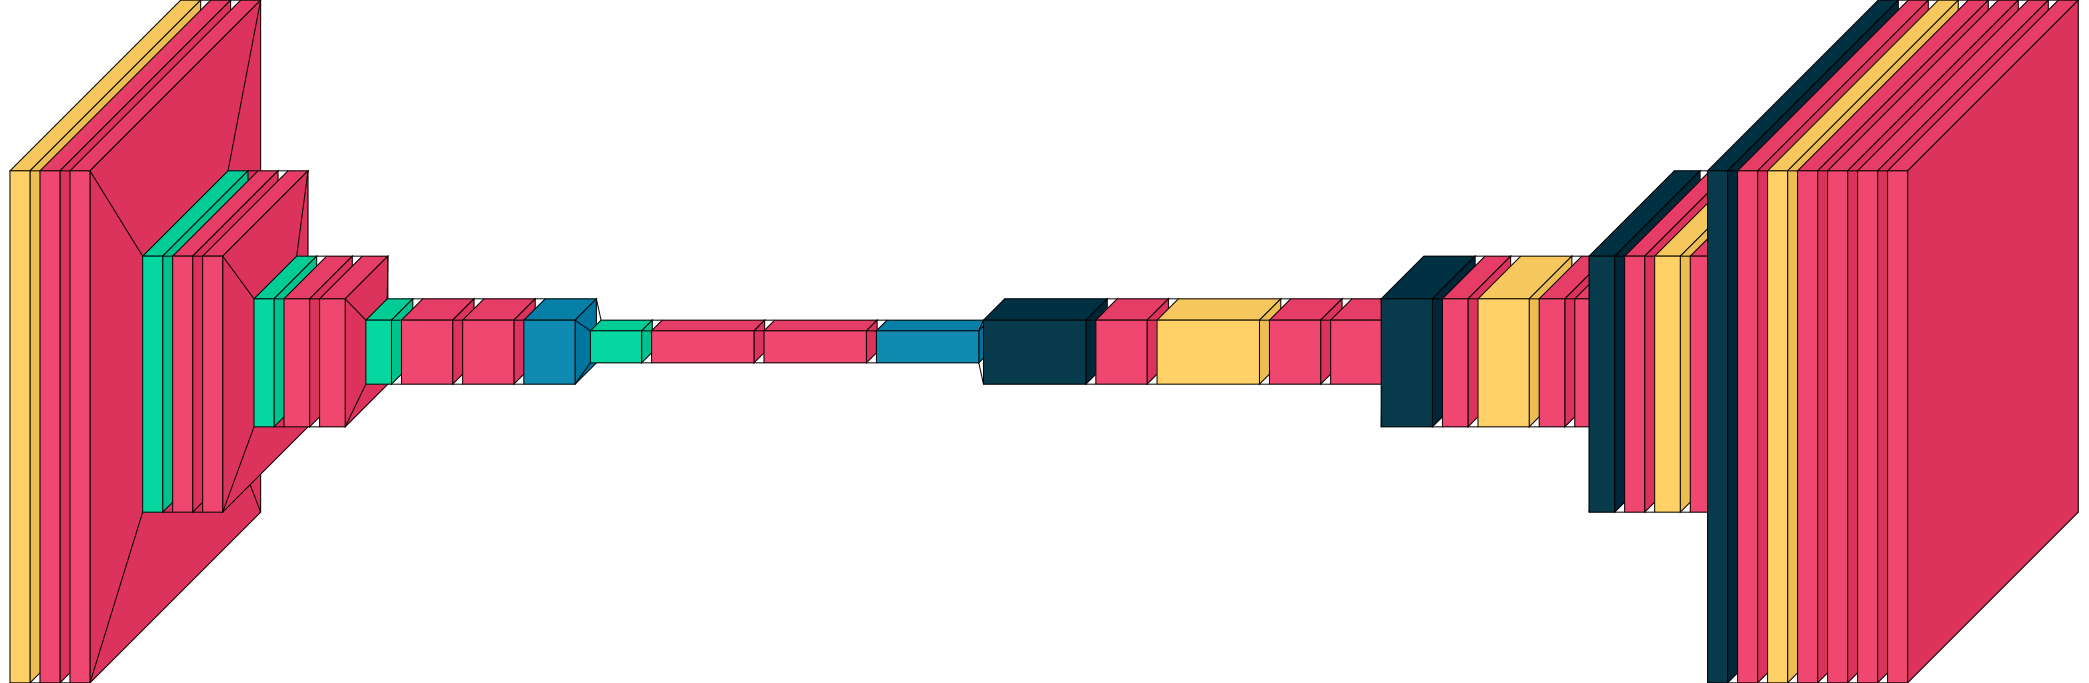

In [5]:
def build_unet():
  inputs = Input((128, 128,1))
  conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
  conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
  pool1 = MaxPool2D(pool_size=(2, 2))(conv1)

  conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
  conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
  pool2 = MaxPool2D(pool_size=(2, 2))(conv2)

  conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
  conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
  pool3 = MaxPool2D(pool_size=(2, 2))(conv3)

  conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
  conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
  drop4 = Dropout(0.5)(conv4)
  pool4 = MaxPool2D(pool_size=(2, 2))(drop4)

  conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
  conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
  drop5 = Dropout(0.5)(conv5)

  up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
  merge6 = concatenate([drop4,up6], axis = 3)
  conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
  conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

  up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
  merge7 = concatenate([conv3,up7], axis = 3)
  conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
  conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

  up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
  merge8 = concatenate([conv2,up8], axis = 3)
  conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
  conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

  up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
  merge9 = concatenate([conv1,up9], axis = 3)
  conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
  conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
  conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
  conv10 = Conv2D(2, 1, activation = 'tanh')(conv9)

  model = Model(inputs,conv10)
  return model

def compile_unet(model):
  opt = Adam(lr=.001)
  #model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
  model.compile(optimizer='rmsprop',loss='mse', metrics=['accuracy'])
  return model

def save_unet(model):
  model.save('unet.h5', overwrite=True)

def load_unet():
  return models.load_model('unet.h5')


### Generator CONV

In [6]:
def build_conv():
  model = Sequential()
  model.add(InputLayer(input_shape=(128, 128, 1)))
  model.add(Conv2D(8, (3, 3), activation='relu', padding='same', strides=2))
  model.add(Conv2D(8, (3, 3), activation='relu', padding='same'))
  model.add(Dropout(0.3))
  model.add(Conv2D(16, (3, 3), activation='relu', padding='same'))
  model.add(Dropout(0.3))
  model.add(Conv2D(16, (3, 3), activation='relu', padding='same', strides=2))
  model.add(Dropout(0.3))
  model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
  model.add(Dropout(0.3))
  model.add(Conv2D(32, (3, 3), activation='relu', padding='same', strides=2))
  model.add(UpSampling2D((2, 2)))
  model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
  model.add(Dropout(0.3))
  model.add(UpSampling2D((2, 2)))
  model.add(Conv2D(16, (3, 3), activation='relu', padding='same'))
  model.add(UpSampling2D((2, 2)))
  model.add(Conv2D(2, (3, 3), activation='tanh', padding='same'))
  return model

def compile_conv(model):
  opt = Adam(lr=.001)
  model.compile(optimizer='rmsprop',loss='mse', metrics=['accuracy'])
  return model

def save_conv(model):
  model.save('conv.h5', overwrite=True)

def load_conv():
  return models.load_model('conv.h5')


### GAN

In [7]:
def build_gan(input_generator, model_discriminator, model_generator):
  gan_input = Input(shape=input_generator)
  generator = model_generator(gan_input)
  model_discriminator.trainable = False
  real_or_fake = model_discriminator(generator)
  gan = Model(gan_input, real_or_fake)
  opt = Adam(lr=.001, beta_1=0.5)
  #gan.compile(loss='binary_crossentropy', optimizer=opt,  metrics=['accuracy'])
  gan.compile(optimizer='rmsprop',loss='mse', metrics=['accuracy'])
  return gan

# GAN

## Grey to RGB

### Train

In [8]:
discriminator = compile_discriminator(build_discriminator())
generator = compile_generator(build_generator())
gan_generator = build_gan((256,256, 1), discriminator, generator)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


ValueError: ignored

In [ ]:
discriminator = compile_discriminator(build_discriminator())
unet = compile_unet(build_unet())
gan_unet = build_gan((256,256, 1), discriminator, unet)

### Test

## L to LAB

### Funciones

In [ ]:
def prepare_images_discriminator_lab(files, model_generator):
  
  # Se cargan todas las imagenes y se transofrman a LAB
  x_true = np.array([np.array(load_image(f)).astype('float32') for f in files])

  # Se copian las imagenes
  x_fake = x_true.copy()

  # Se extrae el canal AB
  x_true = np.array([image_to_lab_ab_norm(image) for image in x_true])

  # Se extra el canal L
  x_fake = np.array([image_to_lab_l_norm(image)  for image in x_fake])
  # Se usa el modelo generador para generar imagenes que se daran como malas
  # Permitiendo mejorar el modelo, se obtienen imagenes con canal AB
  x_fake_model = model_generator.predict(x_fake)

  size = len(x_fake_model)
  # Las imagenes reales con 1 y las predicciones a 0
  y_true = np.ones(len(x_true))
  y_fake = np.zeros(size)

  # Se concatenan
  x = np.concatenate((x_true, x_fake_model))
  y = np.concatenate((y_true, y_fake))

  # Se mezclan
  random.seed(44)
  random.shuffle(x)
  random.seed(44)
  random.shuffle(y)
  random.seed()
  return x, y

# Permite no cargar todas las imagenes a la vez
def batch_images_discriminator_lab(files, batch_size, model_generator):
    
    # Cantidad de ficheros
    L = len(files)

    while True:

        # Batch de inicio y fin
        batch_start = 0
        batch_end = batch_size

        while batch_start < L:
            # Se obtiene el minimo para no pasarse de indice
            limit = min(batch_end, L)

            # Se preparan las imagenes para el batch correspondiente
            X, Y = prepare_images_discriminator_lab(files[batch_start:limit], model_generator)

            # Se pasa a tensor
            X  = tf.convert_to_tensor(X, dtype=tf.float16)
            Y  = tf.convert_to_tensor(Y, dtype=tf.float16)
            yield (X,Y)

            # Se actualizan para el siguiente batch
            batch_start += batch_size   
            batch_end += batch_size


def prepare_images_gan_lab(files):

  # Se cargan las imágenes y se transforman a LAB normalizadas
  x_true = np.array([np.array(load_image(f)).astype('float') for f in files])

  x_true = np.array([image_to_lab(image)[:,:,0] for image in x_true])

  x_true  = tf.convert_to_tensor(x_true, dtype=tf.float16)
  y_true = tf.convert_to_tensor(np.ones(len(x_true)), dtype=tf.float16)

  return x_true, y_true


def batch_images_gan_lab(files, batch_size):

    L = len(files)

    while True:

        batch_start = 0
        batch_end = batch_size

        while batch_start < L:
            limit = min(batch_end, L)
            X, Y = prepare_images_gan_lab(files[batch_start:limit])

            yield (X,Y)

            batch_start += batch_size   
            batch_end += batch_size

### Train

In [ ]:
discriminator = compile_discriminator(build_discriminator())
generator = compile_generator(build_generator())
gan = build_gan((128,128, 1), discriminator, generator)

In [ ]:
file_paths = glob('./*/*.*g')[200:300]
random.shuffle(file_paths)

batch_size = 16
steps_per_epoch = len(file_paths) // batch_size
epochs = 5

batch_images_function = batch_images_discriminator_lab(file_paths, batch_size, generator)
batch_images_function_gan = batch_images_gan_lab(file_paths, batch_size)

with tf.device("/gpu:0"): 
  epoch = 0
  while epoch <= epochs:
    # Permitirmos entrenar el discriminador
    discriminator.trainable = True
    discriminator.fit(batch_images_function, steps_per_epoch=steps_per_epoch, epochs=4)

    # Bloqueamos entrenar el discriminador
    discriminator.trainable = False
    gan.fit(batch_images_function_gan, steps_per_epoch=steps_per_epoch, epochs=1)
    epoch += 1




In [ ]:
generator_unet = compile_unet(build_unet())
gan_unet = build_gan((128,128, 1), discriminator, generator_unet)

In [ ]:
file_paths = glob('./*/*.*g')[200:300]
random.shuffle(file_paths)

batch_size = 16
steps_per_epoch = len(file_paths) // batch_size
epochs = 5

batch_images_function = batch_images_discriminator_lab(file_paths, batch_size, generator)
batch_images_function_gan = batch_images_gan_lab(file_paths, batch_size)

with tf.device("/gpu:0"): 
  epoch = 0
  while epoch <= epochs:
    # Permitirmos entrenar el discriminador
    discriminator.trainable = True
    discriminator.fit(batch_images_function, steps_per_epoch=steps_per_epoch, epochs=4)

    # Bloqueamos entrenar el discriminador
    discriminator.trainable = False
    gan_unet.fit(batch_images_function_gan, steps_per_epoch=steps_per_epoch, epochs=1)
    epoch += 1




### Test

In [ ]:
# Get images
file_paths = glob('./*/*.jpg')
image = np.array(load_image(file_paths[202])).astype('float')

# Import map images into the lab colorspace
X =  image_to_lab(image)[:,:,0].reshape(128, 128, 1)
Y =  image_to_lab(image)[:,:,1:].reshape(128, 128, 2)
# Building the neural network

# Output colorizations
output = generator.predict(np.array([X]))
canvas = np.zeros((128, 128, 3))
canvas[:,:,0] = X[:,:,0]
canvas[:,:,1:] = output[0]

print(output[0])
canvas = cv2.resize(canvas, (image_orig.shape[1], image_orig.shape[0]))

img = color.lab2rgb(canvas)

imgbrg = img.copy()
imgbrg[:,:,0] = img[:,:,2]
imgbrg[:,:,1] = img[:,:,1]
imgbrg[:,:,2] = img[:,:,0]


from matplotlib.pyplot import figure

figure(figsize=(10, 10), dpi=80)

plt.imshow(imgbrg)
plt.show()
#cv2.imsave("img_result.png", color.lab2rgb(canvas))
#cv2.imsave("img_gray_scale.png", color.rgb2gray(lab2rgb(canvas)))

In [ ]:
# Get images
file_paths = glob('./*/*.*g')
image = np.array(load_resize_normalized_lab(file_paths[2])).astype('uint8')

X = lab_l(image.copy())

X = np.array(X).reshape(1, 128, 128, 1)
# Output colorizations
output = generator_unet.predict(X)

canvas = np.zeros((128, 128, 3))
canvas[:,:,0] = image[:,:,0]
canvas[:,:,1:] = output[0]

canvas = de_normalize_array(canvas)
canvas = cv2.resize(canvas, (image.shape[1], image.shape[0]))

img = color.lab2rgb(canvas)
img = de_normalize_array(img)
imgbrg = img.copy()
imgbrg[:,:,0] = img[:,:,2]
imgbrg[:,:,1] = img[:,:,1]
imgbrg[:,:,2] = img[:,:,0]

from matplotlib.pyplot import figure

figure(figsize=(8, 8), dpi=80)

plt.imshow(imgbrg)
plt.show()

# No GAN

### Grey to RGB

### L to LAB

#### Funciones

In [11]:
def prepare_images_gen_lab(files):
  X = []
  Y = []
  for i in range(0, len(files)):
    image = cv2.imread(files[i])
    image = np.array(image, dtype=float)
    # Import map images into the lab colorspace
    image = cv2.resize(image, (128, 128))
    X.append(color.rgb2lab(1.0/255*image)[:,:,0][:, :, np.newaxis])
    Y.append(color.rgb2lab(1.0/255*image)[:,:,1:])

  X =  np.array(X)
  Y =  np.array(Y)
  Y = Y / 128

  return X, Y

# Permite no cargar todas las imagenes a la vez
def batch_images_gen_lab(files, batch_size):
    
    # Cantidad de ficheros
    L = len(files)

    while True:

        # Batch de inicio y fin
        batch_start = 0
        batch_end = batch_size

        while batch_start < L:
            # Se obtiene el minimo para no pasarse de indice
            limit = min(batch_end, L)

            # Se preparan las imagenes para el batch correspondiente
            X, Y = prepare_images_gen_lab(files[batch_start:limit])

            # Se pasa a tensor
            X  = tf.convert_to_tensor(X, dtype=tf.float16)
            Y  = tf.convert_to_tensor(Y, dtype=tf.float16)
            yield (X,Y)

            # Se actualizan para el siguiente batch
            batch_start += batch_size   
            batch_end += batch_size

def train_image_gen_lab(files, model, eporchs):
  batch_size = 16
  steps_per_epoch = len(files) // batch_size

  batch_images_function_gen = batch_images_gen_lab(files, batch_size)
  with tf.device("/gpu:0"): 
      model.fit(batch_images_function_gen, steps_per_epoch=steps_per_epoch, epochs=eporchs)


#### Train


Se pueden ver resultados con un minimo de 500 eporch y muy pocas imágenes

Se crea el modelo geneador, con un learning rate de 0.0001 y como función de pérdida RMSprop

In [ ]:
generator = build_generator()

opt = Adam(lr=.001)
generator.compile(optimizer='rmsprop',loss='mse', metrics=['accuracy'])


In [ ]:
file_paths = glob('./*/*.*g')
random.shuffle(file_paths)
images = file_paths[0:400]

train_image_gen_lab(images, generator, 200)

Se crea el modelo unet, con un learning rate de 0.0001 y como función de pérdida RMSprop

In [ ]:
generator_unet = build_unet()

opt = Adam(lr=.001)
generator_unet.compile(optimizer='rmsprop',loss='mse', metrics=['accuracy'])

In [ ]:
file_paths = glob('./*/*.*g')
random.shuffle(file_paths)
images = file_paths[0:400]

train_image_gen_lab(images, generator_unet, 200)

Se crea el modelo conv, con un learning rate de 0.0001 y como función de pérdida RMSprop

In [29]:
generator_conv = build_conv()

opt = Adam(lr=.0001)
generator_conv.compile(optimizer='rmsprop',loss='mse', metrics=['accuracy'])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
file_paths = glob('./*/*.*g')
random.shuffle(file_paths)
images = file_paths[0:400]


train_image_gen_lab(images, generator_conv, 200)

#### Test

In [14]:
def show_test_image_nogan_lab(image, model):
  image_orig = cv2.imread(image)
  image = np.array(image_orig, dtype=float)

  # Import map images into the lab colorspace
  image = cv2.resize(image, (128, 128))
  X =  np.array(color.rgb2lab(1.0/255*image)[:,:,0])
  Y =  np.array(color.rgb2lab(1.0/255*image)[:,:,1:])
  Y = Y / 128
  X = X.reshape(1, 128, 128, 1)
  Y = Y.reshape(1, 128, 128, 2)

  # Output colorizations
  output = model.predict(X)
  output = output * 128
  canvas = np.zeros((128, 128, 3))
  canvas[:,:,0] = X[0][:,:,0]
  canvas[:,:,1:] = output[0]

  canvas = cv2.resize(canvas, (image_orig.shape[1], image_orig.shape[0]))

  img = color.lab2rgb(canvas)

  imgbrg = img.copy()
  imgbrg[:,:,0] = img[:,:,2]
  imgbrg[:,:,1] = img[:,:,1]
  imgbrg[:,:,2] = img[:,:,0]

  from matplotlib.pyplot import figure

  figure(figsize=(6, 6), dpi=80)

  plt.imshow(imgbrg)
  plt.show()

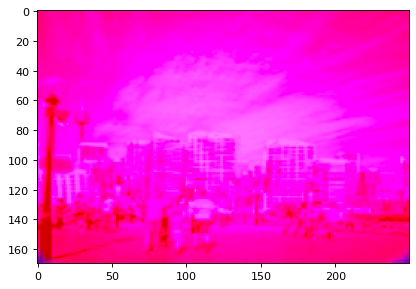

In [32]:
# Get images
file_paths = glob('./*/*.jpg')
show_test_image_nogan_lab(file_paths[202], generator)

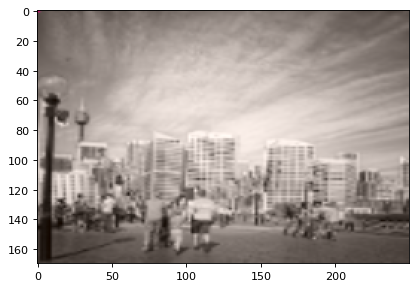

In [25]:
# Get images
file_paths = glob('./*/*.jpg')
show_test_image_nogan_lab(file_paths[202], generator_unet)

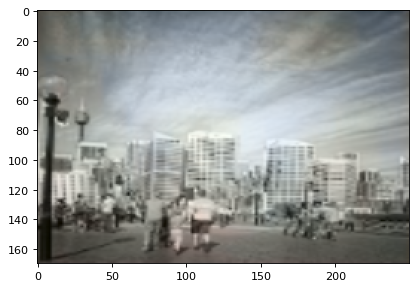

In [31]:
# Get images
file_paths = glob('./*/*.jpg')
show_test_image_nogan_lab(file_paths[202], generator_conv)